# EDA: Fruit Quality Spectral Dataset
Steps:
1. Visualizing the Spectra  
2. Outlier / Noise / Anomaly Detection  
3. Correlation Analysis  
4. Dimensionality Reduction (PCA)  
5. Clustering / Projection (t-SNE & UMAP)  
6. Distribution Analysis of Targets  


In [1]:
# Cell 1: Imports & Styling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import savgol_filter
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Optionally install & import UMAP
try:
    import umap
    has_umap = True
except ImportError:
    has_umap = False

sns.set(style="whitegrid")
%matplotlib inline


## Cell 2: Load & Inspect Data


In [2]:
DATA_PATH = "Assignment_DataScientist_20250502.csv"      # update path if needed
TARGETS   = ["Brix","Firmness (kg)","TA"]  # adjust to your column names

df = pd.read_csv(DATA_PATH)
print("Raw shape:", df.shape)
df.head()


Raw shape: (4876, 122)


,0.25_GHz_real,0.5_GHz_real,0.75_GHz_real,1.0_GHz_real,1.25_GHz_real,1.5_GHz_real,1.75_GHz_real,2.0_GHz_real,2.25_GHz_real,2.5_GHz_real,...,sensorT,TestDate,Experiment,Cultivar,Fruit nr,Size,Weight,Brix,TA,Firmness (kg)
0,0.928321,0.799110,0.607104,0.430211,0.171274,-0.056632,-0.274899,-0.489029,-0.670751,-0.796667,...,54.346122,18/01/2024,1,Cult1,1,3.503926,303,14.0,0.7073,8.391452
1,0.928362,0.795095,0.603138,0.428903,0.171034,-0.059646,-0.285999,-0.501920,-0.681401,-0.802221,...,54.233890,18/01/2024,1,Cult1,1,3.503926,303,14.0,0.7073,8.041279
2,0.920793,0.725661,0.539412,0.415448,0.164646,-0.104585,-0.367430,-0.560130,-0.722270,-0.831610,...,54.128772,18/01/2024,1,Cult1,2,2.992117,184,13.4,0.7651,8.201397
3,0.929618,0.756798,0.573948,0.448641,0.212831,-0.047378,-0.304099,-0.503503,-0.677524,-0.808135,...,54.123407,18/01/2024,1,Cult1,2,2.992117,184,13.4,0.7651,8.771562
4,0.924183,0.735891,0.556284,0.417789,0.169946,-0.098664,-0.358264,-0.553657,-0.715784,-0.827924,...,54.094455,18/01/2024,1,Cult1,3,3.011802,171,12.8,0.6108,7.321428


## Cell 3: Visualizing the Raw Spectra
Plot a few random spectra to see overall shape and noise.


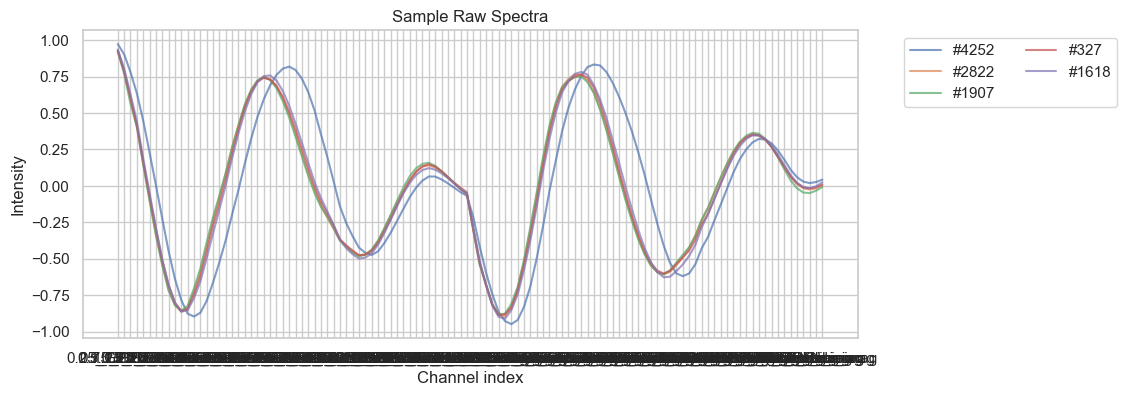

In [3]:
# Spectral columns = first 112 columns (real+imag)
spec_cols = df.columns[:112]

plt.figure(figsize=(10,4))
for i in np.random.choice(len(df), size=5, replace=False):
    plt.plot(df.iloc[i, :112], alpha=0.7, label=f"#{i}")
plt.title("Sample Raw Spectra")
plt.xlabel("Channel index")
plt.ylabel("Intensity")
plt.legend(ncol=2, bbox_to_anchor=(1.05,1), loc="upper left")
plt.show()


## Cell 4: Outlier / Noise / Anomaly Detection
Compute **max z-score** per sample and visualize.


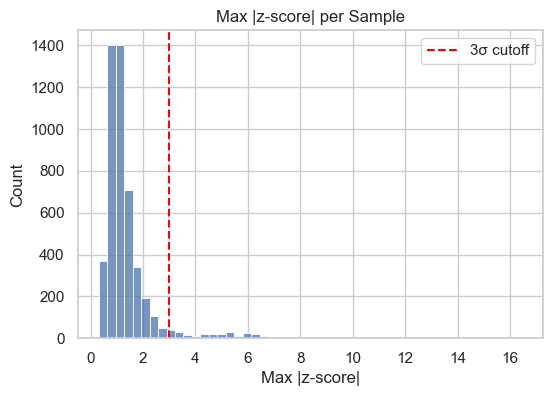

Outliers above 3σ: 295 of 4876


In [4]:
numeric = df[spec_cols]
z = (numeric - numeric.mean())/numeric.std()
max_z = z.abs().max(axis=1)

plt.figure(figsize=(6,4))
sns.histplot(max_z, bins=50)
plt.axvline(3, color="red", linestyle="--", label="3σ cutoff")
plt.title("Max |z-score| per Sample")
plt.xlabel("Max |z-score|")
plt.ylabel("Count")
plt.legend()
plt.show()

print("Outliers above 3σ:", (max_z>3).sum(), "of", len(df))


## Cell 5: Clean Data by Removing Outliers


In [5]:
mask = max_z <= 3
df_clean = df.loc[mask].reset_index(drop=True)
print("After cleaning:", df_clean.shape)


After cleaning: (4581, 122)


## Cell 6: Correlation Analysis
Spectral–target and inter-target correlations.


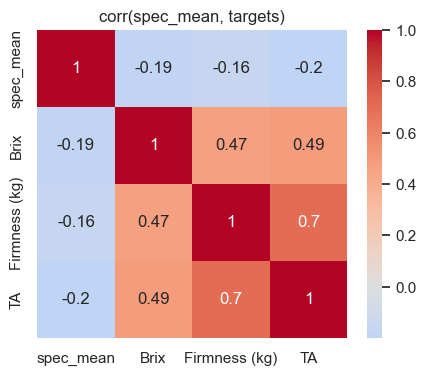

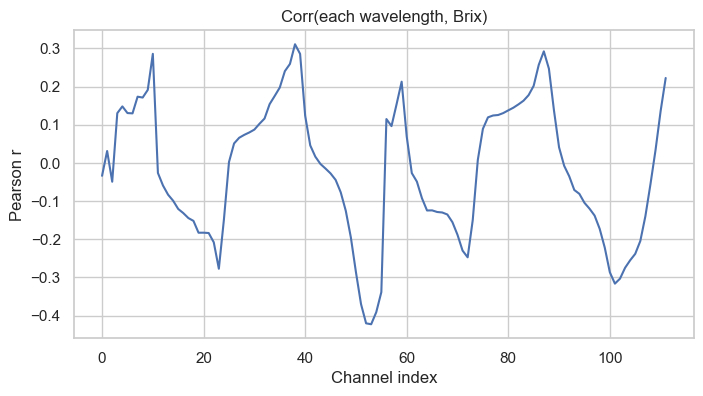

In [6]:
# Correlation between spectral mean & targets
df_clean["spec_mean"] = df_clean[spec_cols].mean(axis=1)
corr1 = df_clean[["spec_mean"]+TARGETS].corr()

plt.figure(figsize=(5,4))
sns.heatmap(corr1, annot=True, cmap="coolwarm", center=0)
plt.title("corr(spec_mean, targets)")
plt.show()

# Full spectral-feature correlation with one target (e.g. Brix)
plt.figure(figsize=(8,4))
speccorr = df_clean[spec_cols].corrwith(df_clean[TARGETS[0]])
plt.plot(speccorr.values)
plt.title(f"Corr(each wavelength, {TARGETS[0]})")
plt.xlabel("Channel index")
plt.ylabel("Pearson r")
plt.show()


## Cell 7: PCA (Linear Dimensionality Reduction)


Explained var ratio: [0.67956186 0.13315878] Total: 0.812720644668645


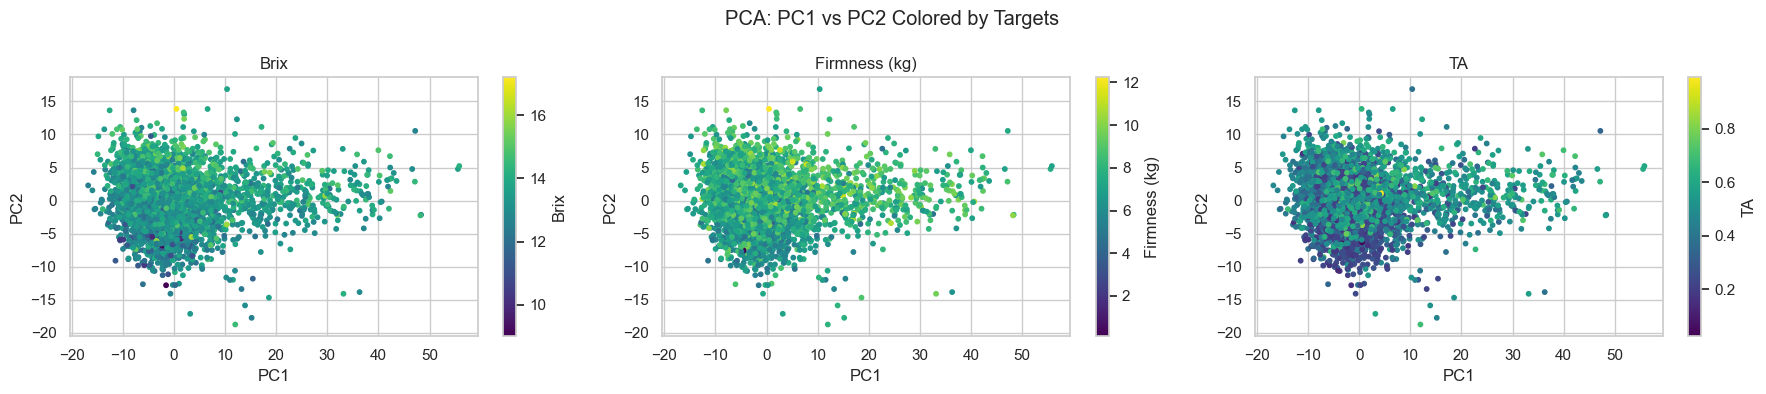

In [7]:
X = StandardScaler().fit_transform(df_clean[spec_cols])
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
print("Explained var ratio:", pca.explained_variance_ratio_, "Total:", sum(pca.explained_variance_ratio_))

fig, axes = plt.subplots(1,3,figsize=(18,4))
for i, tgt in enumerate(TARGETS):
    sc = axes[i].scatter(X_pca[:,0], X_pca[:,1],
                         c=df_clean[tgt], cmap="viridis", s=10)
    axes[i].set_title(tgt)
    axes[i].set_xlabel("PC1"); axes[i].set_ylabel("PC2")
    plt.colorbar(sc, ax=axes[i], label=tgt)
plt.suptitle("PCA: PC1 vs PC2 Colored by Targets")
plt.tight_layout()
plt.show()


## Cell 8: Clustering / Projection (t-SNE & UMAP)


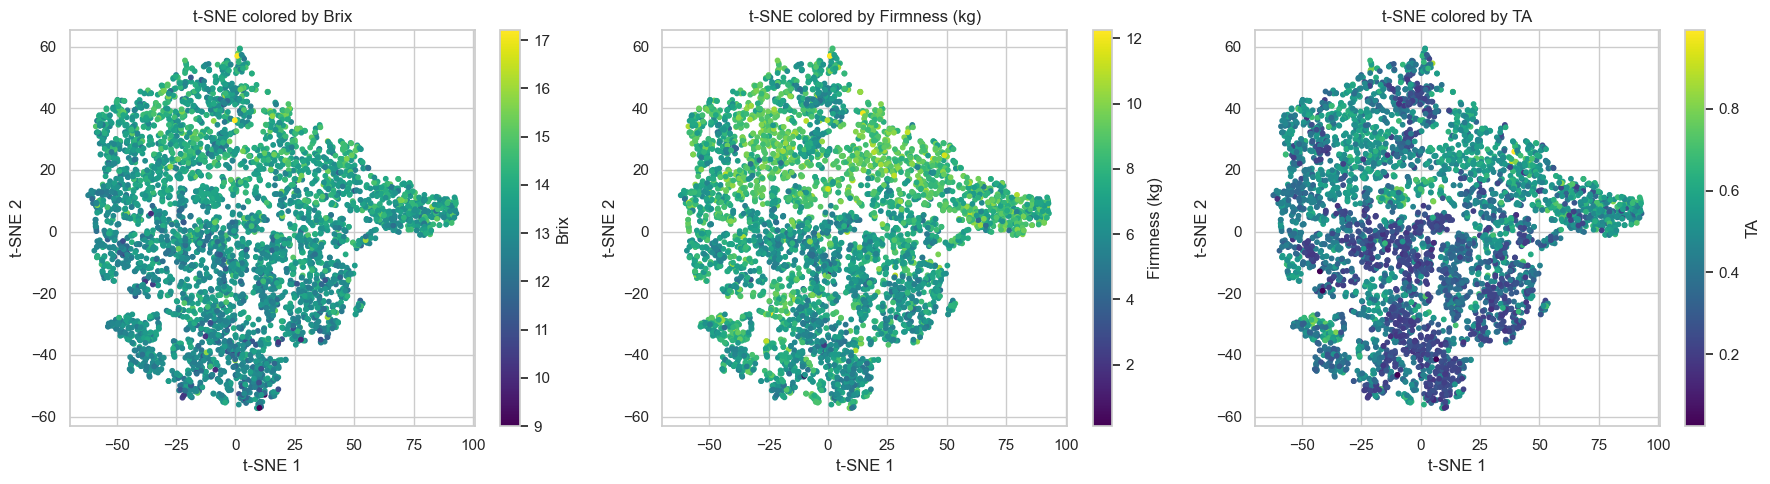

In [11]:
# Cell: t-SNE & UMAP for All Targets
from sklearn.manifold import TSNE

# 1) Prepare data
X = StandardScaler().fit_transform(df_clean[spec_cols].values)

# 2) t-SNE projection
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X)

# 3) UMAP projection (if installed)
if has_umap:
    import umap
    reducer = umap.UMAP(n_components=2, random_state=42)
    X_umap = reducer.fit_transform(X)

# 4) Plotting
fig, axes = plt.subplots(2 if has_umap else 1, 3, figsize=(18, 5*(2 if has_umap else 1)))

# --- t-SNE row ---
for i, target in enumerate(TARGETS):
    ax = axes[0, i] if has_umap else axes[i]
    sc = ax.scatter(X_tsne[:, 0], X_tsne[:, 1],
                    c=df_clean[target], s=10, cmap='viridis')
    ax.set_title(f"t-SNE colored by {target}")
    ax.set_xlabel("t-SNE 1")
    ax.set_ylabel("t-SNE 2")
    plt.colorbar(sc, ax=ax, label=target)

# --- UMAP row (optional) ---
if has_umap:
    for i, target in enumerate(TARGETS):
        ax = axes[1, i]
        sc = ax.scatter(X_umap[:, 0], X_umap[:, 1],
                        c=df_clean[target], s=10, cmap='viridis')
        ax.set_title(f"UMAP colored by {target}")
        ax.set_xlabel("UMAP 1")
        ax.set_ylabel("UMAP 2")
        plt.colorbar(sc, ax=ax, label=target)

plt.tight_layout()
plt.show()



## Cell 9: Distribution Analysis of Targets


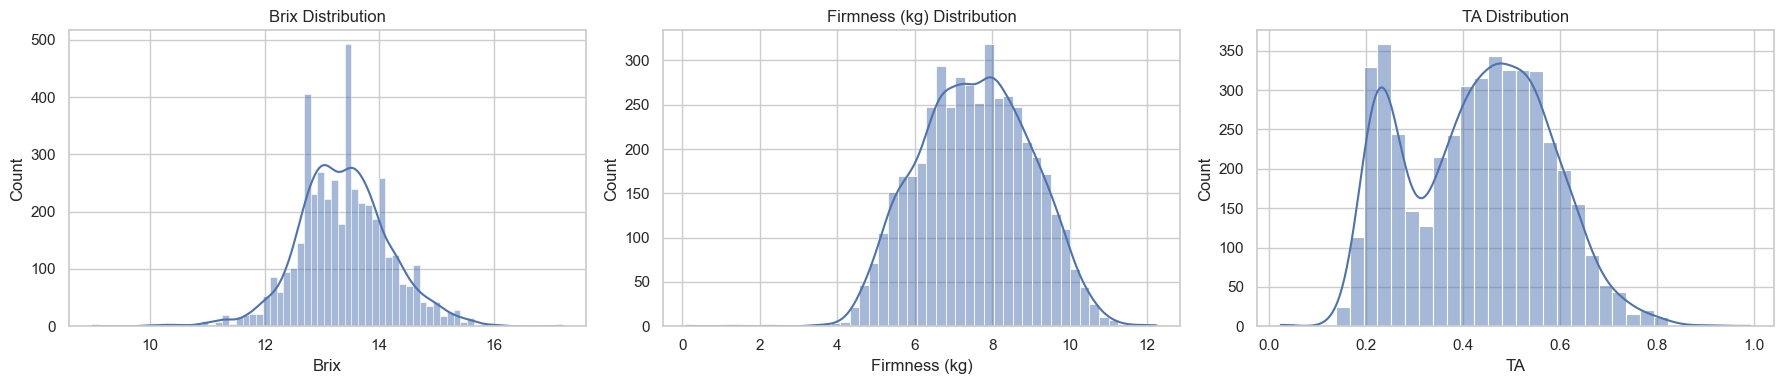

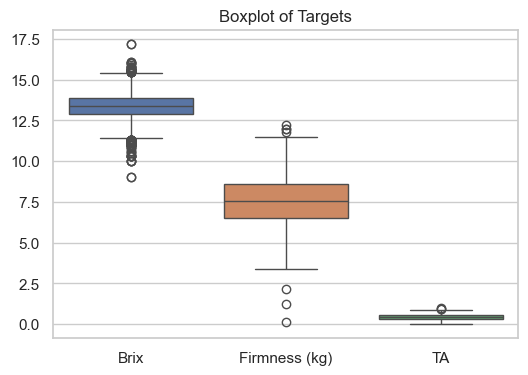

In [9]:
fig, axes = plt.subplots(1,3,figsize=(18,4))
for i, tgt in enumerate(TARGETS):
    sns.histplot(df_clean[tgt], kde=True, ax=axes[i])
    axes[i].set_title(f"{tgt} Distribution")
    axes[i].set_xlabel(tgt)
plt.tight_layout()
plt.show()

# Boxplots to see outliers per target
plt.figure(figsize=(6,4))
sns.boxplot(data=df_clean[TARGETS])
plt.title("Boxplot of Targets")
plt.show()
